In [1]:
#--Tracées statiques
import numpy as np
import matplotlib.pyplot as plt 
#--Gestion dimensions subplots
import matplotlib.gridspec as gridspec 
#import matplotlib.widgets as mwg
import ipywidgets as widgets

#--Expressions régulières
import os
import re
import sys
import glob
#-*- coding: utf-8 -*-
import codecs

#--Panda: creer un document csv
import pandas as pd

#Tracées dynamiques et options dash
import plotly as py
import plotly.graph_objs as go
import plotly.express as px

#--Processing
import scipy.fftpack
from scipy import signal
#-Pour autocorrelation
import scipy.stats
from scipy.signal import savgol_filter

In [2]:
%matplotlib notebook

# <font color=red> Compte rendu

## <font color=green> Traitement des données expérimentales
        
On va ici extraire d'un fichier texte, les données brutes issues d'un montage expérimentale. \
Ensuite il s'agira de faire apparaître les grandeurs physiques d'intérêts. 

In [3]:
#--Constantes
rho = 1.204
nu = 1.5e-5
H = 0.072
W = 0.098
R = 0.01235
w_slit = 1.7e-3

#--lecture des données
# file_name=
# path1=os.getcwd()
# print(path1)
# for root, dirs, files in os.walk(path1):
#     for f in files:
#         print(f,type(f))
#         if f==f_1:
#             r=root
#             break
#     else: 
#         continue
#     break
dic = {}
for u in glob.glob("Input/Fichiers/*.txt"):
    #* Améliorer le dictionnaire
    date = re.compile('(\d+)(\w+)(\d+)').search(u).group(1)
    data = np.transpose(np.loadtxt(u))
    dic[date] = data

#--Données physiques
#-temps
time = data[0]
#-fréquence d'échantillonage    
fe = 1/(data[0][1]-data[0][0])
#-pression de Pitot
Ppitot = data[9:11]
#-Vitesse
#* Est ce que U est un réel pur Luc?
U = np.sqrt((Ppitot[1]-Ppitot[0])/(0.5*rho))
#-Pression dynamique
P_rem = 0.5*rho*np.mean(U)**2
#-Grandeurs adimensionnées
Pbase = data[1:5]/P_rem
Pnose = data[5]/P_rem
Cb = np.mean(Pbase)
#-gradient de pression
Pup = Pbase[1]-Pbase[0]
Pdwn = Pbase[3]-Pbase[2]
DCPY = (Pup+Pdwn)/(2*57/72)
Pl = Pbase[0]-Pbase[2]
Pr = Pbase[1]-Pbase[3]
DCPZ = (Pl+Pr)/(2*40/72)


#--Histogramme
dic = {'time':time, 'vitesse':U, 'dPy':DCPY, 'dPz':DCPZ}
df = pd.DataFrame(dic)

<IPython.core.display.Javascript object>


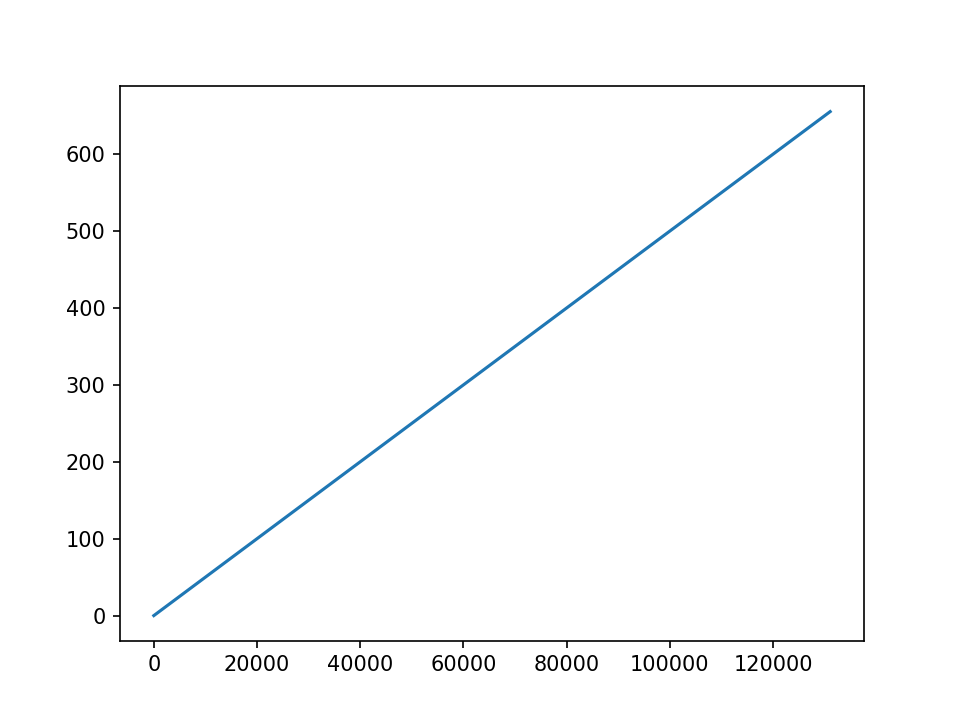

In [4]:
#--Traitement du temps
25*W/np.mean(U)
H/W
5/6

# u = np.arange(10)
# print(u)
# plt.plot(dic['time'])
t = dic['time']
t[65535:]=t[65535:]+t[65534]
plt.plot(dic['time'])
plt.show()

## <font color=green> Représentation du signal

### Spectre simple (avec transformée de fourier)


#### Spectre avec welch

il faudrait un moyen pour trouver automatiquement les fréquences du spectre et chercher quel rapport de fréquence se rapproche le plus du rapport de forme aller voir:
[Detection d un pic](https://gist.github.com/endolith/255291#file-readme-md) 

<IPython.core.display.Javascript object>


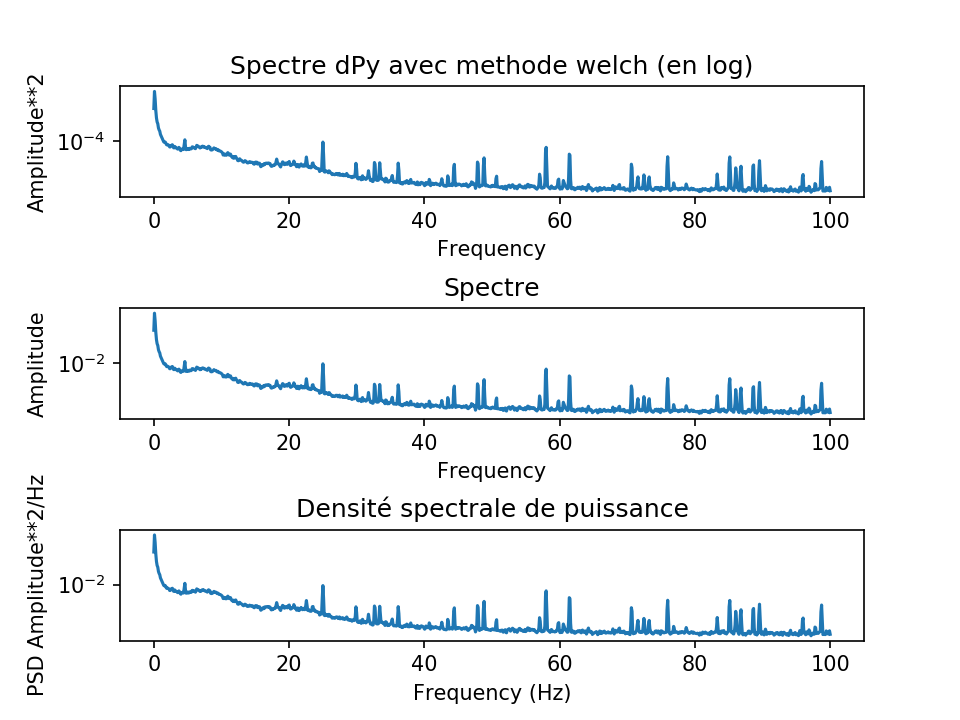

<IPython.core.display.Javascript object>


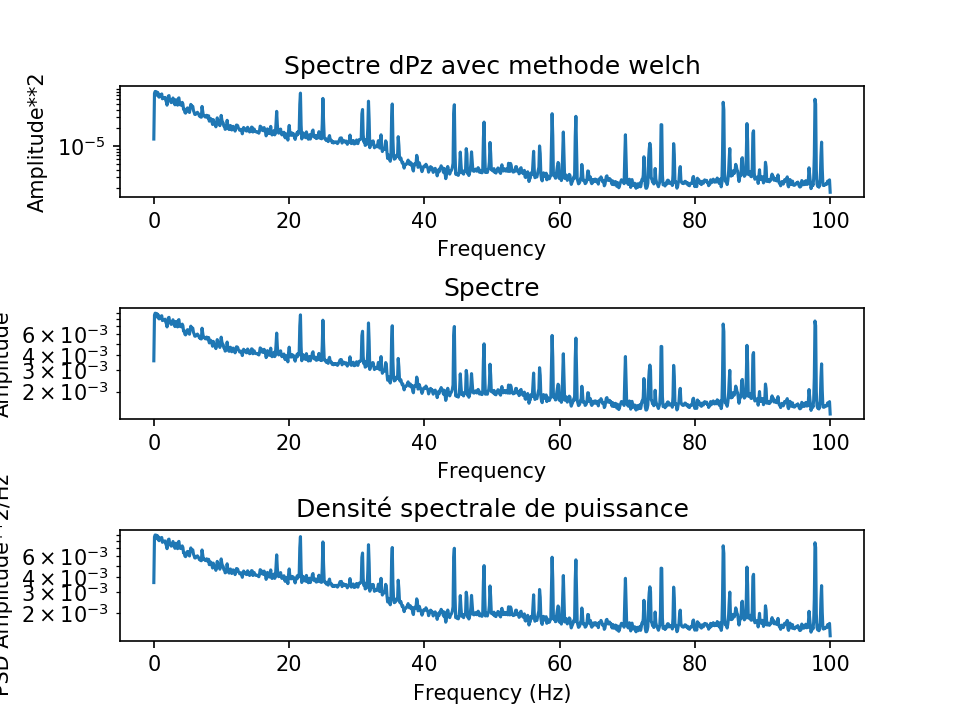

In [5]:
#-- Utilisation de la méthode welch (nperseg= multiple de 2)
"""
nperseg=
8192
4096
2048
1024
512
256
    """

freqs2, psd2 = signal.welch(dic['dPy'], fe, 'hanning', scaling='density', nperseg= 2048)
figure, axis = plt.subplots(3,1)

plt.subplots_adjust(hspace=1)
axis[0].set_title('Spectre dPy avec methode welch (en log)')
axis[0].semilogy(freqs2, psd2)
# axis[0].plot(freqs2, psd2)
axis[0].set_xlabel('Frequency')
axis[0].set_ylabel('Amplitude**2')

axis[1].set_title('Spectre')
axis[1].semilogy(freqs2, np.sqrt(psd2))
axis[1].set_xlabel('Frequency')
axis[1].set_ylabel('Amplitude')


axis[2].set_title('Densité spectrale de puissance')
axis[2].semilogy(freqs2, np.sqrt(psd2))
axis[2].set_xlabel('Frequency (Hz)')
axis[2].set_ylabel('PSD Amplitude**2/Hz')
plt.show()

freqs2, psd2 = signal.welch(dic['dPz'], fe, 'hanning', scaling='density', nperseg= 2048)
figure, axis = plt.subplots(3,1)
plt.subplots_adjust(hspace=1)
axis[0].set_title('Spectre dPz avec methode welch')
axis[0].semilogy(freqs2, psd2)
axis[0].set_xlabel('Frequency')
axis[0].set_ylabel('Amplitude**2')

axis[1].set_title('Spectre')
axis[1].semilogy(freqs2, np.sqrt(psd2))
axis[1].set_xlabel('Frequency')
axis[1].set_ylabel('Amplitude')


axis[2].set_title('Densité spectrale de puissance')
axis[2].semilogy(freqs2, np.sqrt(psd2))
axis[2].set_xlabel('Frequency (Hz)')
axis[2].set_ylabel('PSD Amplitude**2/Hz')
plt.show()

### Filtrage

Le signal étant trop bruité, il faut le corriger.\
Plusieurs solutions: 
<ul>
<li>Filtrage passe bas: le bruit étant notamment dû aux vibrations de la structure qui sont plus hautes que le signal d'intérêt. 
filtrage simple, filtrage butterworth..?</li>
<li>Technique de smoothing: méthodes d'interpolations..</li>
</ul>   

Effet du filtrage sur le spectre

#### Filtre passe bas simple 
[filtrage passe bas simple](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html)
#### Filtre passe bas Butterworth
[filtrage passe bas Butterworth](https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units)
#### Smooth 1
[Smooth 1](https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way)
#### Smooth 2
[Smooth 2](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html)


Rajoute un 2 autres figures avec option zoom
Rajouter boutons fenêtrage spectre (hanning, blackarris..)

<IPython.core.display.Javascript object>


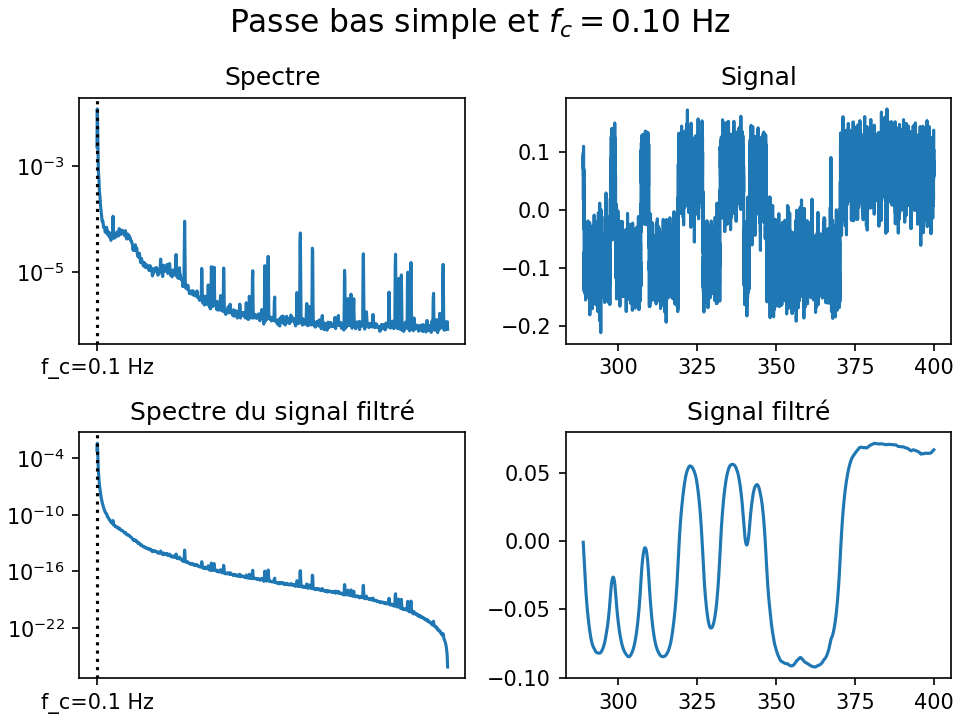

interactive(children=(IntSlider(value=0, description='choix', max=3), IntSlider(value=1, description='ordre', …

In [12]:
#--Input
fs = fe
t = time
y_input = dic['dPy']

#--Transformée de Fourier méthode welch
# fs = fe
# N = Ns
# yf_input = scipy.fft(y_input)
# freqs1, psd1 = signal.welch(y_input, fe, 'hanning', scaling='density', nperseg=2048)
# freqs2, psd2 = signal.welch(y_output_list[0], fe, 'hanning', scaling='density', nperseg=2048)
# f = np.linspace(0.0, 1.0/(2.0/fs), N//2)
# yf_output = scipy.fft(y_output)

#--option zoom
t_z = [289,289.4]
t_z_index = [np.where(time==t_z[0])[0][0], np.where(time==t_z[1])[0][0] ]



#--Figure
#-Output
# y_output = y_output_list[0]
# fig0 = plt.figure(constrained_layout=True)
# spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig0)
# f2_ax1 = fig0.add_subplot(spec2[0, 0])
# f2_ax1.semilogy(freqs1, psd1)
# f2_ax2 = fig0.add_subplot(spec2[0, 1])
# f2_ax2.plot(time[t_z_index[0]:t_z_index[1]], y_input[t_z_index[0]:t_z_index[1]])
# f2_ax3 = fig0.add_subplot(spec2[1, 0])
# f2_ax3.semilogy(freqs2, psd2)
# f2_ax4 = fig0.add_subplot(spec2[1, 1])
# f2_ax4.plot(time[t_z_index[0]:t_z_index[1]], y_output[t_z_index[0]:t_z_index[1]])
# fig2.suptitle("Filtrage simple, fréquance de coupure f_c={:.2f}".format(f_c))
# fig0.show()

# y_output_list =[y_output1, y_output2, y_output3, y_output4]
# def update_plot(choix):
    
#     y_output = y_output_list[choix]
#     freqs1, psd1 = signal.welch(y_input, fe, 'hanning', scaling='density', nperseg=2048)
#     freqs2, psd2 = signal.welch(y_output, fe, 'hanning', scaling='density', nperseg=2048)
    
#     f2_ax1 = fig0.add_subplot(spec2[0, 0])
#     f2_ax1.clear()
#     f2_ax1.semilogy(freqs1, psd1)
    
    
#     f2_ax2 = fig0.add_subplot(spec2[0, 1])
#     f2_ax2.clear()
#     f2_ax2.plot(time[t_z_index[0]:t_z_index[1]], y_input[t_z_index[0]:t_z_index[1]])
    
    
#     f2_ax3 = fig0.add_subplot(spec2[1, 0])
#     f2_ax3.clear()
#     f2_ax3.semilogy(freqs2, psd2)
    
#     f2_ax4 = fig0.add_subplot(spec2[1, 1])
#     f2_ax4.clear()
#     f2_ax4.plot(time[t_z_index[0]:t_z_index[1]], y_output[t_z_index[0]:t_z_index[1]])
    
#     fig0.suptitle("Traitement numéro {0}  f_c={1:.2f}".format(choix, f_c))
#     fig0.show()
    

# fig0 = plt.figure(constrained_layout=True)
# spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig0)
# choix = widgets.IntSlider(min=0, max=3, label="Processing type")
# widgets.interactive(update_plot, choix=choix)

def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth



#--option zoom
t_z = [289,289.4]
t_z = [289,400]
t_z_index = [np.where(time==t_z[0])[0][0], np.where(time==t_z[1])[0][0] ]
# t_z_index = [0, len(time)-1]
def update_plot(choix, ordre, f_c):
    
    #--Filtrage 
    #-Filtre 1 passe bas avec fréquence de coupure du signal à 30 Hz
    w = f_c / (fs/2)
    #print("w = {}".format(w))
    b, a = signal.butter(ordre, w, 'low')
    y_output1 = signal.filtfilt(b, a, y_input)

    #-Filtre 2: passe bas Butterworth 
    sample_rate = fe
    y_output2 = butter_lowpass_filter(y_input, f_c, sample_rate/2, ordre)

    #-Smooth 1
    y_output3 = smooth(y_input, ordre)

    #-Smooth 2
    window_size = 51
    y_output4 = savgol_filter(y_input, window_size, ordre) # window size 51, polynomial order 3

    #-output
    y_output_list =[y_output1, y_output2, y_output3, y_output4]
    filtrage = ['Passe bas simple', 'Passe bas butterworth', 'Smoothing 1', 'Smoothing 2']
    y_output = y_output_list[choix]
    
    #--Spectre welch
    freqs1, psd1 = signal.welch(y_input, fe, 'hanning', scaling='density', nperseg=2048)
    freqs2, psd2 = signal.welch(y_output, fe, 'hanning', scaling='density', nperseg=2048)

    f2_ax1 = fig0.add_subplot(spec2[0, 0])
    f2_ax1.clear()
    f2_ax1.semilogy(freqs1, psd1)
    f2_ax1.set_title("Spectre")
    if choix<=1:
        f2_ax1.axvline(x=f_c,linestyle=':', color='black')
        plt.setp(f2_ax1,xticks=[f_c], xticklabels=['f_c={} Hz'.format(f_c)])


    f2_ax2 = fig0.add_subplot(spec2[0, 1])
    f2_ax2.clear()
    f2_ax2.plot(time[t_z_index[0]:t_z_index[1]], y_input[t_z_index[0]:t_z_index[1]])
    f2_ax2.set_title("Signal")


    f2_ax3 = fig0.add_subplot(spec2[1, 0])
    f2_ax3.clear()
    f2_ax3.semilogy(freqs2, psd2)
    f2_ax3.set_title("Spectre du signal filtré")
    if choix<=1:
        f2_ax3.axvline(x=f_c,linestyle=':', color='black')
        plt.setp(f2_ax3,xticks=[f_c], xticklabels=['f_c={} Hz'.format(f_c)])

    f2_ax4 = fig0.add_subplot(spec2[1, 1])
    f2_ax4.clear()
    f2_ax4.plot(time[t_z_index[0]:t_z_index[1]], y_output[t_z_index[0]:t_z_index[1]])
    f2_ax4.set_title("Signal filtré")
    
    if choix<=1:
        fig0.suptitle("{0} et ".format(filtrage[choix])+r'$f_{c}=$'+"{0:.2f} Hz".format(f_c), fontsize=15)
    else:
        fig0.suptitle("{0}".format(filtrage[choix]), fontsize=15)
    fig0.show()
        
    

fig0 = plt.figure(constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig0)
choix = widgets.IntSlider(min=0, max=3, label="Processing type")
f_c = widgets.FloatSlider(min=0.1, max=80, step=0.1, label="fréquence de coupure")
ordre = widgets.IntSlider(min=1, max=30, label="Ordre")
widgets.interactive(update_plot, choix=choix, f_c=f_c, ordre=ordre)

#### Comparaison signal filtré et signal non filtré

<IPython.core.display.Javascript object>


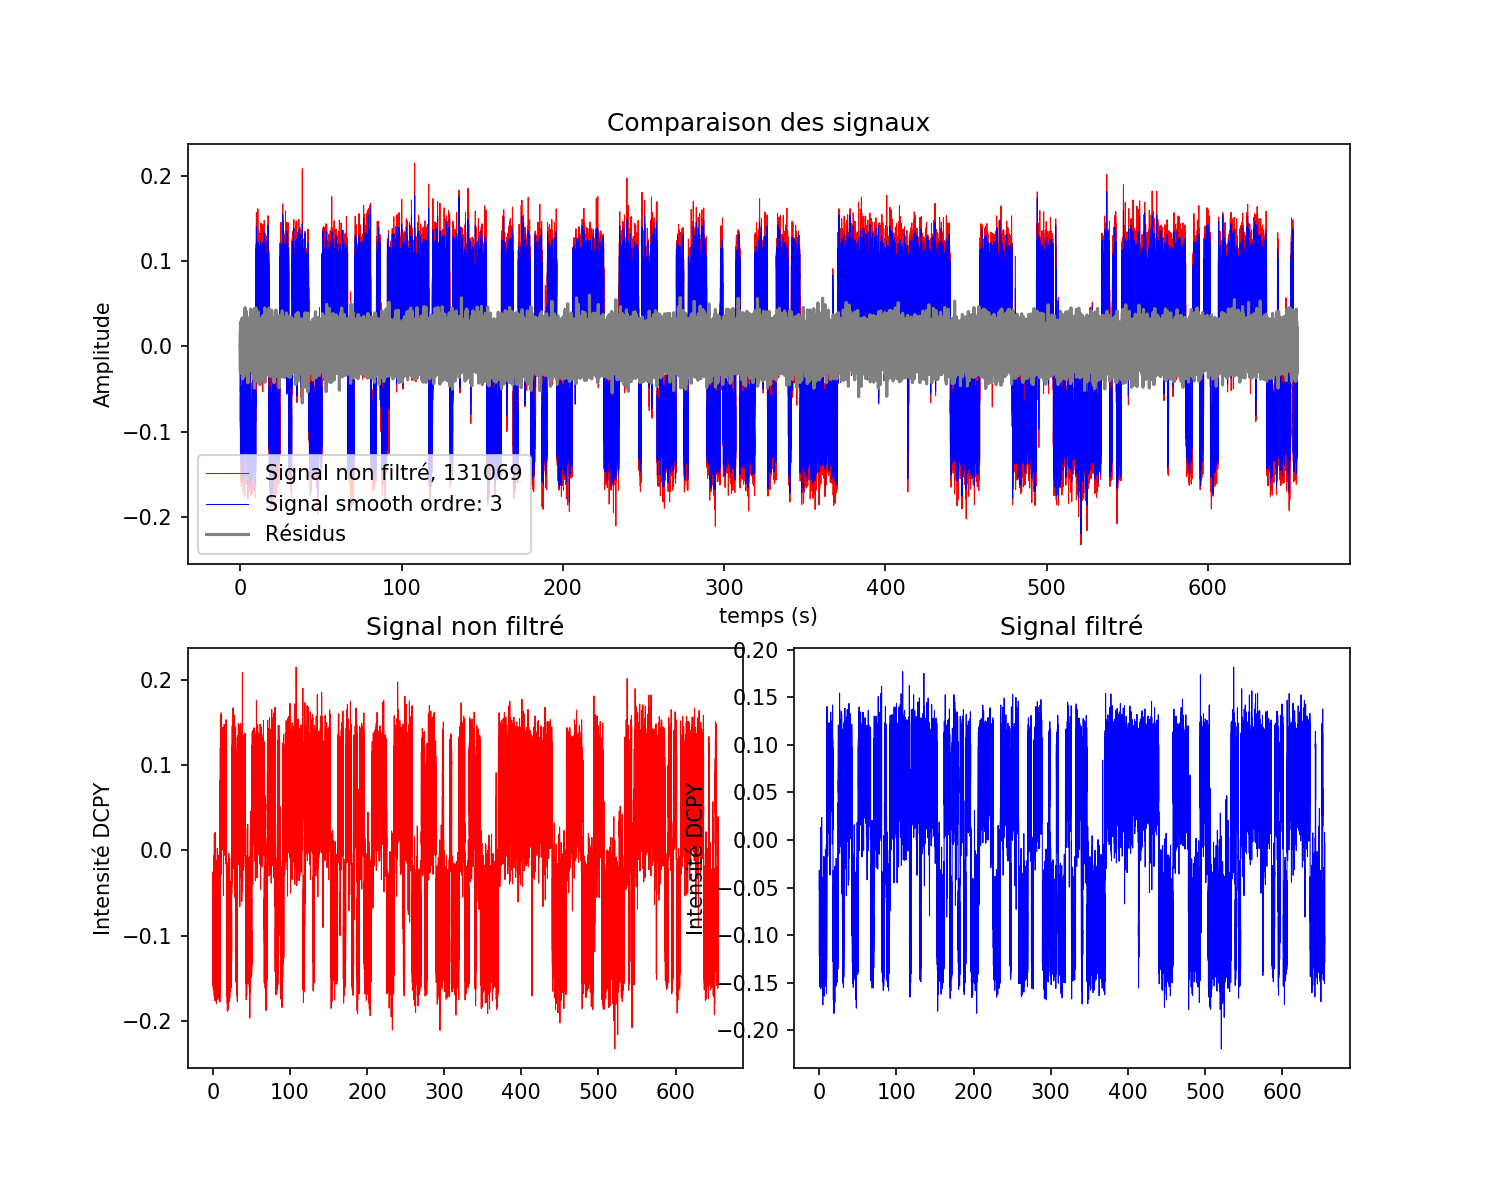

In [15]:
f_c = 30
ordre = 3

#--Filtrage 
#-Filtre 1 passe bas avec fréquence de coupure du signal à 30 Hz
w = f_c / (fs/2)
#print("w = {}".format(w))
b, a = signal.butter(ordre, w, 'low')
y_output1 = signal.filtfilt(b, a, y_input)

#-Filtre 2: passe bas Butterworth 
sample_rate = fe
y_output2 = butter_lowpass_filter(y_input, f_c, sample_rate/2, ordre)

#-Smooth 1
y_output3 = smooth(y_input, ordre)

#-Smooth 2
window_size = 51
y_output4 = savgol_filter(y_input, window_size, ordre) # window size 51, polynomial order 3

#-output
y_output_list =[y_output1, y_output2, y_output3, y_output4]

y_output=y_output_list[1]
diff =y_output-y_input

fig2 = plt.figure(figsize=(10,8))#constrained_layout=True)
gs = fig2.add_gridspec(2, 4)
f3_ax1 = fig2.add_subplot(gs[0, :])
f3_ax1.set_title("Comparaison des signaux")
f3_ax1.plot(time, y_input, color='red', lw=0.5, label="Signal non filtré, {}".format(len(y_input)-1))
f3_ax1.plot(time, y_output, color='blue', lw=0.5, label="Signal smooth ordre: {}".format(ordre))
f3_ax1.plot(time, diff, color='gray', label="Résidus")
f3_ax1.set_xlabel('temps (s)')
f3_ax1.set_ylabel('Amplitude')
f3_ax1.legend()

f3_ax2 = fig2.add_subplot(gs[1, :-2])
f3_ax2.set_title("Signal non filtré")
f3_ax2.plot(time, y_input, color='red', lw=0.5, label="Signal non filtré, {}".format(len(y_input)-1))
f3_ax2.set_ylabel('Intensité DCPY')

f3_ax3 = fig2.add_subplot(gs[1, 2:])
f3_ax3.set_title("Signal filtré")
f3_ax3.plot(time, y_output, color='blue', lw=0.5, label="Signal smooth ordre: {}".format(ordre))
f3_ax3.set_ylabel('Intensité DCPY')
plt.show()

## <font color=green> Portrait de phase
    
<ul>
<li>Tester l autocorrelation DCPY avec et sans filtre</li>
<li>Une fois $\frac{T}{4}$ connu tracé du portrait de phase (3d, 2d..)  avec et sans filtre</li>
</ul> 

#### Autocorrelation du signal DCPy

In [16]:
print(len(time))
result = [pd.Series(y_input).autocorr(n) for n in range(len(time-1))]
plt.figure()
plt.plot(time, result)
plt.title("Autocorrelation du signal")
plt.ylabel("Coeff_pearson")
plt.xlabel("Decalage temporelle")
plt.show()

131070


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning:

Degrees of freedom <= 0 for slice

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning:

divide by zero encountered in true_divide



<IPython.core.display.Javascript object>

#### Représentation du signal pur et son autocorrelation

<IPython.core.display.Javascript object>


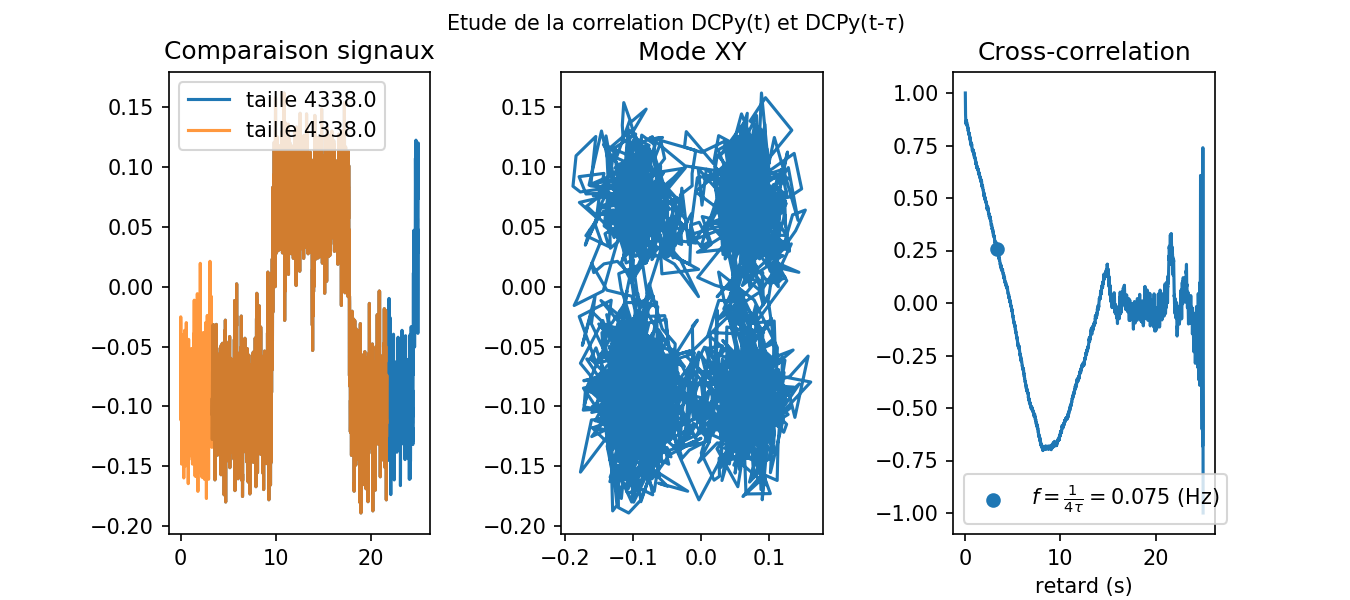

interactive(children=(FloatSlider(value=0.01, description='retard', max=25.0, min=0.01, step=0.005), Output())…

In [20]:
zoom = 5000
time_zoom = time[:zoom]
y_input_zoom = y_input[:np.where(time==time[zoom])[0][0]]
DT = time_zoom[1]-time_zoom[0]

def plot_update(retard):
    
    retard_index = np.where(time_zoom==retard)[0][0]
    #-Comparaisons des signaux
    axis[0].clear()
    axis[0].plot(time_zoom[retard_index:], y_input_zoom[retard_index:], label='taille {:.1f}'.format(len(y_input_zoom[retard_index:])))
    axis[0].plot(time_zoom[:-retard_index], y_input_zoom[:-retard_index], alpha=0.8, label='taille {:.1f}'.format(len(y_input_zoom[:-retard_index])))
#   axis[0].axhline(0, color='black', lw=0.6) #, label='phase={:.0f}°'.format(phase))
    axis[0].legend(loc='best')
    axis[0].set_title('Comparaison signaux')

    #
    axis[1].clear()
    axis[1].plot(y_input_zoom[retard_index:], y_input_zoom[:-retard_index]) #, label='phase={:.0f}°'.format(phase))
    #axis[1].legend(loc='best')
    axis[1].set_title('Mode XY')
    

    corr = [pd.Series(y_input_zoom).autocorr(n) for n in range(len(time_zoom-1))]
    corr1 = scipy.stats.pearsonr(y_input_zoom[retard_index:], y_input_zoom[:-retard_index])[0]
    axis[2].clear()
    axis[2].scatter(retard, corr1, label= r'$f=\frac{1}{4 \tau}=$'+"{:.3f} (Hz)".format(1/(4*retard)))
    axis[2].plot(time_zoom, corr)
    axis[2].set_title('Cross-correlation')
    axis[2].set_xlabel('retard (s)')
    axis[2].legend()
    
    
    fig1.show()
    
fig1, axis = plt.subplots(1, 3, figsize=(9, 4))
fig1.suptitle(r'Etude de la correlation DCPy(t) et DCPy(t-$\tau$)', fontsize=10)
plt.subplots_adjust(wspace=0.5, hspace=1)
retard = widgets.FloatSlider(min=time_zoom[1], max=time_zoom[-1:], step=0.005, description='retard')
#u_0 = widgets.FloatSlider(min=0, max=2, value=1, description=r'$u_{0}$')
widgets.interactive(plot_update, retard=retard)




#### Représentation du signal traité et son autocorrelation

In [18]:
#---Liste des methodes pour épurer le signal du bruit
ordre = 3
f_c = 20
#--Filtre 1 passe bas avec fréquence de coupure du signal à 30 Hz
w = f_c / (fs/2)
#print("w = {}".format(w))
b, a = signal.butter(ordre, w, 'low')
y_output1 = signal.filtfilt(b, a, y_input_zoom)

#--Filtre 2: passe bas Butterworth 
def butter_lowpass(cutoff, nyq_freq, order=4):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order=4):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

#--Filtre 3 Butterworth
sample_rate = fe

y_output2 = butter_lowpass_filter(y_input_zoom, f_c, sample_rate/2, ordre)

#--Smooth 1
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

y_output3 = smooth(y_input_zoom, ordre)


#--Smooth 2
window_size = 51
y_output4 = savgol_filter(y_input_zoom, window_size, ordre) # window size 51, polynomial order 3


y_output =[y_output1, y_output2, y_output3, y_output4]

def plot_update(retard, choix):
    
    retard_index = np.where(time_zoom==retard)[0][0]
    #-Comparaisons des signaux
    axis[0].clear()
    axis[0].plot(time_zoom[retard_index:], y_output[choix][retard_index:], label='taille {:.1f}'.format(len(y_input_zoom[retard_index:])))
    axis[0].plot(time_zoom[:-retard_index], y_output[choix][:-retard_index], alpha=0.8, label='taille {:.1f}'.format(len(y_input_zoom[:-retard_index])))
#   axis[0].axhline(0, color='black', lw=0.6) #, label='phase={:.0f}°'.format(phase))
    axis[0].legend(loc='best')
    axis[0].set_title('Comparaison signaux')

    #
    axis[1].clear()
    axis[1].plot(y_output[choix][retard_index:], y_output[choix][:-retard_index]) #, label='phase={:.0f}°'.format(phase))
    #axis[1].legend(loc='best')
    axis[1].set_title('Mode XY')
    

    corr = [pd.Series(y_output[choix]).autocorr(n) for n in range(len(time_zoom-1))]
    corr1 = scipy.stats.pearsonr(y_output[choix][retard_index:], y_output[choix][:-retard_index])[0]
    axis[2].clear()
    axis[2].scatter(retard, corr1, color='r', label= r'$f=\frac{1}{4 \tau}=$'+"{:.3f} (Hz)".format(1/(4*retard)))
    axis[2].plot(time_zoom, corr)
    axis[2].set_title('Cross-correlation')
    axis[2].set_xlabel('retard (s)')
    axis[2].legend()
    
    fig2.show()
    
fig2, axis = plt.subplots(1, 3, figsize=(9, 4))
fig2.suptitle(r'Etude de la correlation DCPy(t) et DCPy(t-$\tau$)', fontsize=10)
plt.subplots_adjust(wspace=0.5, hspace=1)
choix = widgets.IntSlider(min=0, max=3, description='Type\n de traitement')
retard = widgets.FloatSlider(min=time_zoom[1], max=time_zoom[-1:], step=0.005, description='retard')
#u_0 = widgets.FloatSlider(min=0, max=2, value=1, description=r'$u_{0}$')
widgets.interactive(plot_update, retard=retard, choix=choix)

<IPython.core.display.Javascript object>

interactive(children=(FloatSlider(value=0.01, description='retard', max=25.0, min=0.01, step=0.005), IntSlider…